## Используем препроцессинг с прошлых лаб..

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('../telco.csv')
data.drop(['customerID'],axis=1,inplace=True)

categorical_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
for column in categorical_columns:
    data[column] = data[column].astype('category')

data['gender']=data['gender'].replace('Male',1)
data['gender']=data['gender'].replace('Female',0)

yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for column in yes_no_columns:
    data[column]=data[column].replace('No',0)
    data[column]=data[column].replace('Yes',1)

binary_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',  'PaperlessBilling', 'Churn']

for column in binary_columns:
    data[column] = data[column].astype('bool')

data['TotalCharges'] = data['TotalCharges'].replace(r'\s+', np.nan, regex=True)
data['TotalCharges'] = data['TotalCharges'].astype('float64')

print(data.dtypes)

data.dropna(inplace=True)
data = pd.get_dummies(data, categorical_columns)

for column in ['tenure', 'MonthlyCharges', 'TotalCharges']:
    data[column] = (data[column] - data[column].mean())/data[column].std()


gender                  bool
SeniorCitizen           bool
Partner                 bool
Dependents              bool
tenure                 int64
PhoneService            bool
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling        bool
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn                   bool
dtype: object


In [2]:
from sklearn.model_selection import train_test_split

X = data.drop(['Churn'], axis=1)
y = data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)

In [3]:
from sklearn.neural_network import MLPClassifier

## Построим классификатор на основе нейронных сетей

In [4]:
mlp_model = MLPClassifier(random_state = 42)
mlp_model.fit(X_train, y_train)
print(mlp_model)

MLPClassifier(random_state=42)


In [5]:
print(f"Accuracy on the train: {mlp_model.score(X_train, y_train) :.5}\n"
      f"Accuracy on the test:  {mlp_model.score(X_test, y_test)   :.5}")

Accuracy on the train: 0.85677
Accuracy on the test:  0.7763


При стандартных параметрах сети точность уже достатоно неплохая. Это соизмеримо с тем, что было получено в прошлых лабах с помощью "классических" алгоритмов (там точность была в районе 78-81%)

Поиграем с параметрами сети: <br>

Попробуем отследить качество модели в зависимости от количества нейронов на слое, а за одно проверить модель на предмет переобучения<br><br>
Однослойная:

In [6]:
from tqdm import tqdm
neurons_per_layer = [1, 10, 25, 50, 100, 200, 250]
train_acc = []
test_acc = []
for first in tqdm(neurons_per_layer):
    mlp_model = MLPClassifier(hidden_layer_sizes = (first,), random_state = 42)
    mlp_model.fit(X_train, y_train)
    train_acc.append(mlp_model.score(X_train, y_train))
    test_acc.append(mlp_model.score(X_test, y_test))

100%|██████████| 7/7 [01:02<00:00,  8.91s/it]


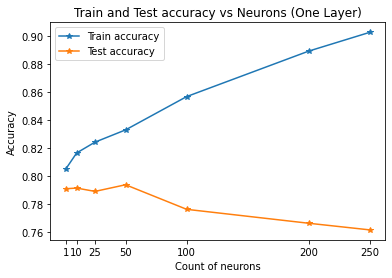

In [7]:
import matplotlib.pyplot as plt

plt.plot(neurons_per_layer, train_acc, marker='*', label="Train accuracy")
plt.plot(neurons_per_layer, test_acc, marker='*', label="Test accuracy")
plt.title("Train and Test accuracy vs Neurons (One Layer)")
plt.xlabel('Count of neurons')
plt.ylabel("Accuracy")
plt.xticks(neurons_per_layer)
plt.legend()

Очевидно, что при больших значениях количества нейронов на слое начинается переобучение и качество модели лучше не становится: точность на треировочных данных растет, однако,на тестовых падает, что свидетельствует о том, что модель просто начала "заучивать" ответы. <br> 
Возьмем 50 нейронов на первом слое в качестве оптимального значения. <br>


In [8]:
index_for_first_layer = neurons_per_layer.index(50)
print(f"Best parametr: {neurons_per_layer[index_for_first_layer]} train acc {train_acc[index_for_first_layer]} test acc {test_acc[index_for_first_layer]}")

Best parametr: 50 train acc 0.8329947175944737 test acc 0.7938388625592417


Попробуем добавить второй слой...

In [10]:
train_acc_two_layers = []
test_acc_two_layers  = []

for second in tqdm(neurons_per_layer):
    mlp_model = MLPClassifier(hidden_layer_sizes = (neurons_per_layer[index_for_first_layer], second), random_state = 42)
    mlp_model.fit(X_train, y_train)
    train_acc_two_layers.append(mlp_model.score(X_train, y_train))
    test_acc_two_layers.append(mlp_model.score(X_test, y_test))

100%|██████████| 7/7 [01:40<00:00, 14.41s/it]


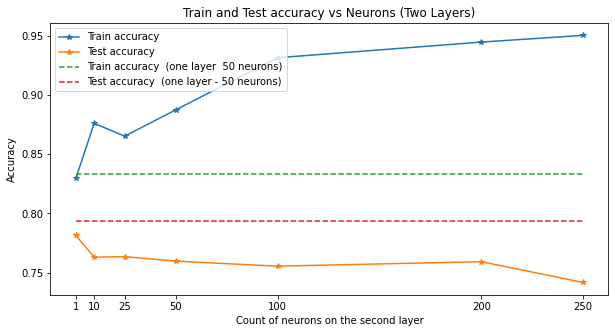

In [12]:
plt.figure(figsize=((10, 5)))
plt.plot(neurons_per_layer, train_acc_two_layers, marker='*', label="Train accuracy")
plt.plot(neurons_per_layer, test_acc_two_layers, marker='*', label="Test accuracy")

plt.plot(neurons_per_layer,
        [train_acc[index_for_first_layer]]*len(neurons_per_layer),
        linestyle='--', 
        label="Train accuracy  (one layer  50 neurons)")

plt.plot(neurons_per_layer,
        [test_acc[index_for_first_layer]]*len(neurons_per_layer), 
        linestyle='--', 
        label="Test accuracy  (one layer - 50 neurons)")

plt.title("Train and Test accuracy vs Neurons (Two Layers)")
plt.xlabel('Count of neurons on the second layer')
plt.ylabel("Accuracy")
plt.xticks(neurons_per_layer)
plt.legend()

Похоже, что при добавлении второго слоя вновь происходит переобучение модели,  так точность на тренировочных данных возросла, но на тестовых - упала. Попробуем уменьшить количеств нейронов на первом слое, чтобы добавить второй слой без ущерба качеству

In [13]:
train_acc_two_layers_2 = []
test_acc_two_layers_2  = []

for second in tqdm(neurons_per_layer):
    mlp_model = MLPClassifier(hidden_layer_sizes = (neurons_per_layer[index_for_first_layer-1], second), random_state = 42)
    mlp_model.fit(X_train, y_train)
    train_acc_two_layers_2.append(mlp_model.score(X_train, y_train))
    test_acc_two_layers_2.append(mlp_model.score(X_test, y_test))

100%|██████████| 7/7 [01:19<00:00, 11.35s/it]


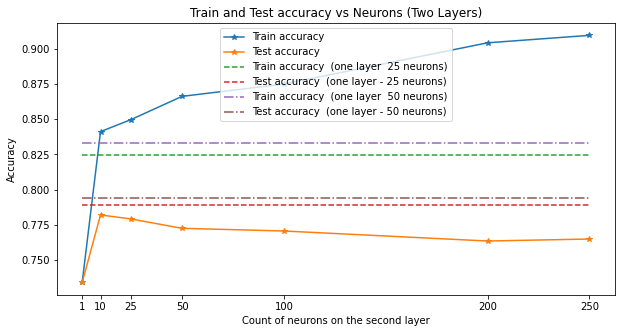

In [15]:
plt.figure(figsize=((10, 5)))
plt.plot(neurons_per_layer, train_acc_two_layers_2, marker='*', label="Train accuracy")
plt.plot(neurons_per_layer, test_acc_two_layers_2, marker='*', label="Test accuracy")

plt.plot(neurons_per_layer,
        [train_acc[index_for_first_layer-1]]*len(neurons_per_layer),
        linestyle='--', 
        label="Train accuracy  (one layer  25 neurons)")

plt.plot(neurons_per_layer,
        [test_acc[index_for_first_layer-1]]*len(neurons_per_layer), 
        linestyle='--', 
        label="Test accuracy  (one layer - 25 neurons)")

plt.plot(neurons_per_layer,
        [train_acc[index_for_first_layer]]*len(neurons_per_layer),
        linestyle='-.', 
        label="Train accuracy  (one layer  50 neurons)")

plt.plot(neurons_per_layer,
        [test_acc[index_for_first_layer]]*len(neurons_per_layer), 
        linestyle='-.', 
        label="Test accuracy  (one layer - 50 neurons)")

plt.title("Train and Test accuracy vs Neurons (Two Layers)")
plt.xlabel('Count of neurons on the second layer')
plt.ylabel("Accuracy")
plt.xticks(neurons_per_layer)
plt.legend()

Похоже, что смысла использовать второй слой в данной задаче нет, так как это попросту вызывает переобучение и намного лучше использовать 1 скрытый слой из 50-нейронов. На этом и остановимся <br>
Попробуем подобрать оптмальный параметр alpha

In [28]:
alphas = np.logspace(-5, 5, 11)
train_per_aplhas = []
test_per_aplhas  = []
layers = (neurons_per_layer[index_for_first_layer])

for alpha in tqdm(alphas):
    mlp_model = MLPClassifier(alpha = alpha , hidden_layer_sizes = layers, random_state = 42)
    mlp_model.fit(X_train, y_train)
    train_per_aplhas.append(mlp_model.score(X_train, y_train))
    test_per_aplhas.append(mlp_model.score(X_test, y_test))

100%|██████████| 11/11 [01:09<00:00,  6.28s/it]


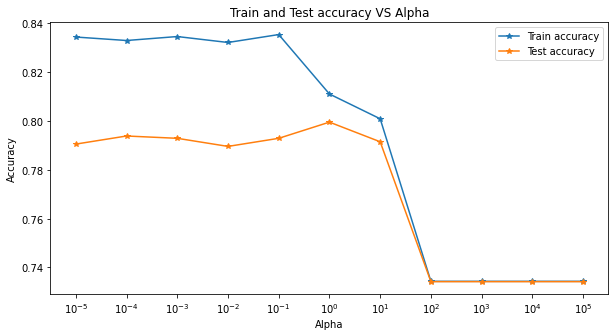

In [33]:
plt.figure(figsize=((10, 5)))
plt.semilogx(alphas, train_per_aplhas, marker='*', label="Train accuracy")
plt.semilogx(alphas, test_per_aplhas, marker='*', label="Test accuracy")

plt.title("Train and Test accuracy VS Alpha")
plt.xlabel('Alpha')
plt.ylabel("Accuracy")
plt.xticks(alphas)
plt.legend()

Похоже, что наилучшая точность модели достигается при значении alpha около единицы. В данной точке наибольшее значение точности на тестовых данных и не очень большая разница между точностью на тестовой и обучающей выборках, что может свидетельствовать о низком (или отсутствии)  переобучения. Рассмотрим эту область поточнее

In [37]:
alphas[np.argmax(test_per_aplhas)]

1.0

In [50]:
alphas_details = np.logspace(-1, 2, 13)
train_per_aplhas_det = []
test_per_aplhas_det  = []

for alpha in tqdm(alphas_details):
    mlp_model = MLPClassifier(alpha = alpha , hidden_layer_sizes = layers, random_state = 42)
    mlp_model.fit(X_train, y_train)
    train_per_aplhas_det.append(mlp_model.score(X_train, y_train))
    test_per_aplhas_det.append(mlp_model.score(X_test, y_test))

100%|██████████| 13/13 [00:59<00:00,  4.61s/it]


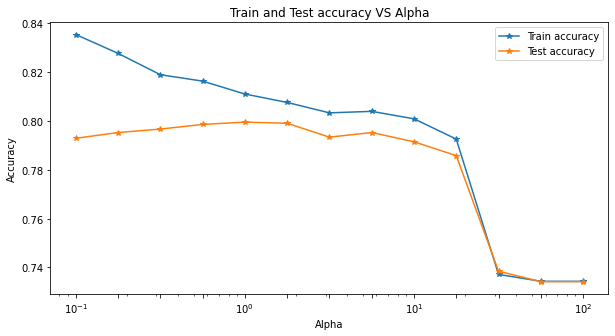

In [51]:
plt.figure(figsize=((10, 5)))
plt.semilogx(alphas_details, train_per_aplhas_det, marker='*', label="Train accuracy")
plt.semilogx(alphas_details, test_per_aplhas_det, marker='*', label="Test accuracy")

plt.title("Train and Test accuracy VS Alpha")
plt.xlabel('Alpha')
plt.ylabel("Accuracy")
plt.xticks(alphas_details)
plt.legend()

Похоже, что ничего не поменялось и лучшая точность достигается при альфа равном 1

In [54]:
alpha_best_index = np.argmax(test_per_aplhas_det)
print(f'Alpha: {alphas_details[alpha_best_index]} Train accuracy {train_per_aplhas_det[alpha_best_index]} Test accuracy {test_per_aplhas_det[alpha_best_index]} ')

Alpha: 1.0 Train accuracy 0.8110524177163755 Test accuracy 0.7995260663507109 


In [55]:
best_model = MLPClassifier(alpha = 1.0 , hidden_layer_sizes = layers, random_state = 42)
best_model.fit(X_train, y_train)

MLPClassifier(alpha=1.0, hidden_layer_sizes=50, random_state=42)

In [57]:
from sklearn.metrics import *
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print(confusion_matrix(y_test_pred, y_test))
print(classification_report(y_test, y_test_pred))

[[1420  294]
 [ 129  267]]
              precision    recall  f1-score   support

       False       0.83      0.92      0.87      1549
        True       0.67      0.48      0.56       561

    accuracy                           0.80      2110
   macro avg       0.75      0.70      0.71      2110
weighted avg       0.79      0.80      0.79      2110



В целом качество данной модели получилось практически таким же, как и при использовании классических алгоритмов. Более того, итоговые метрики также близки к предыдущим метрикам. <br>
В результате имеем, что наилучшая модель получается при использовании 1-го скрытого слоя из 50 нейронов и альфа равным 1. В противном случае при увеличении количества слоев/нейронов модель быстро начинает переобучаться, а при уменьшении - выдавать плохие результаты на обех выборках. в случае параметра альфа имеем следующее: при уменьшении параметра возникает переобучение, а при увеличении - падение качества модели (что-то вроде недообучения, однако качество не падает ниже константы 74%)